# Demo notebook for generating simple plots from PyBpod nwb files (exported from DataJoint)

In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO

nwb_folder = '/root/capsule/data/foraging_nwb_bonsai_processed'

In [46]:
def create_arrays(df, feature):

    # create 'arrays' which contains a separate NumPy array for each unique 'feature' value,
    # each array consisting of rows with (session, foraging_eff, feature)

    # Group by 'effective_block_length_min'
    groups = df.groupby(('metadata', feature))

    # Initialize an empty list to store the arrays
    arrays = []

    for name, group in groups:
        # Extract 'session' and 'foraging_eff' values
        # Adjust this line if 'session' is indexed differently in your DataFrame
        sessions = group.index.get_level_values('session') if 'session' in group.index.names else group['session']
        foraging_eff = group[('session_stats', 'foraging_eff')]

        # Create an array for the 'effective_block_length_min' value, repeated for each row in the group
        effective_block_length_max_values = np.repeat(name, len(group))

        # Combine into a single array
        combined_array = np.array([sessions, foraging_eff, effective_block_length_max_values]).T  # Transpose to get rows of (session, foraging_eff, effective_block_length_min)

        arrays.append(combined_array)

    return arrays

def slice_dataframe(df, feature):
    
    # create new dataframe with desired subsets of info sliced from original dataframe
    # foraging efficiency, feature, session date columns, with session value as the index
    
    # Extract 'session' and 'session_date' assuming they're part of the DataFrame's index
    if 'session' in df.index.names and 'session_date' in df.index.names:
        session_values = df.index.get_level_values('session')
        session_date_values = df.index.get_level_values('session_date')
    else:
        # Adjust these lines if 'session' and 'session_date' are stored differently; these are placeholders
        session_values = df['session']  # This needs adjustment if 'session' is structured differently
        session_date_values = df['session_date']  # Adjust this if 'session_date' is structured differently

    # Extract 'foraging_eff' and 'effective_block_length_min' values from 'subject_df'
    foraging_eff_values = df[('session_stats', 'foraging_eff')]
    effective_block_length_max_values = df[('metadata', feature)]

    # Create a DataFrame with 'foraging_eff', 'effective_block_length_min', and 'session_date'
    new_df = pd.DataFrame({
        'session_date': session_date_values,
        'foraging_eff': foraging_eff_values,
        'effective_block_length_max': effective_block_length_max_values
    })

    # Set 'session' as the index of the new DataFrame
    new_df.index = session_values  # Ensure this matches how 'session' values are extracted above

    # Optionally, name the index 'session' for clarity
    new_df.index.name = 'session'
    
    return new_df

In [20]:
df_sessions = pd.read_pickle(nwb_folder + '/df_sessions.pkl')
df_sessions.sort_values('session_date', ascending=False)
#all_subject_ids = np.unique(df_sessions.index.get_level_values('subject_id').tolist())


metadata                  \
                                                rig       user_name   
subject_id session_date session nwb_suffix                            
722683     2024-04-16   7.0     153946      447-3-C      Xinxin Yin   
717474     2024-04-16   5.0     155012      447-3-A      Xinxin Yin   
708299     2024-04-16   38.0    104116      447-2-D  Travis Ramirez   
711254     2024-04-16   22.0    153313      447-1-C      Xinxin Yin   
711256     2024-04-16   22.0    153649      447-2-C      Xinxin Yin   
...                                             ...             ...   
668463     2023-07-10   2.0     0           Tower-1           Lucas   
671087     2023-07-10   2.0     0           Tower-1          Travis   
668463     2023-07-07   1.0     1           Tower-1           Lucas   
671087     2023-07-06   1.0     0           Tower-1          Travis   
668551     2023-06-15   1.0     3           Tower-5           Lucas   

                                                                   \
                                           experiment_description   
subject_id session_date session nwb_suffix                          
722683     2024-04-16   7.0     153946                              
717474     2024-04-16   5.0     155012                              
708299     2024-04-16   38.0    104116                              
711254     2024-04-16   22.0    153313                              
711256     2024-04-16   22.0    153649                              
...                                                           ...   
668463     2023-07-10   2.0     0                                   
671087     2023-07-10   2.0     0                                   
668463     2023-07-07   1.0     1                                   
671087     2023-07-06   1.0     0                                   
668551     2023-06-15   1.0     3                                   

                                                                       \
                                                                 task   
subject_id session_date session nwb_suffix                              
722683     2024-04-16   7.0     153946              Uncoupled Baiting   
717474     2024-04-16   5.0     155012                        RewardN   
708299     2024-04-16   38.0    104116      Uncoupled Without Baiting   
711254     2024-04-16   22.0    153313              Uncoupled Baiting   
711256     2024-04-16   22.0    153649      Uncoupled Without Baiting   
...                                                               ...   
668463     2023-07-10   2.0     0                     Coupled Baiting   
671087     2023-07-10   2.0     0                     Coupled Baiting   
668463     2023-07-07   1.0     1                     Coupled Baiting   
671087     2023-07-06   1.0     0                     Coupled Baiting   
668551     2023-06-15   1.0     3             Coupled Without Baiting   

                                                                                               \
                                                                                        notes   
subject_id session_date session nwb_suffix                                                      
722683     2024-04-16   7.0     153946           input L 1, laser 1.5\ninput R 0.9, laser 1.5   
717474     2024-04-16   5.0     155012                                                          
708299     2024-04-16   38.0    104116                                                          
711254     2024-04-16   22.0    153313      Left input: 1, power: 1.5; Right input: 0.8, p...   
711256     2024-04-16   22.0    153649                           L 0.7v, 1.5mw\n R 0.8, 1.5mw   
...                                                                                       ...   
668463     2023-07-10   2.0     0                                                               
671087     2023-07-10   2.0     0                                                       

In [90]:
df_sessions.metadata.columns

Index(['rig', 'user_name', 'experiment_description', 'task', 'notes',
       'session_start_time', 'session_end_time', 'session_run_time_in_min',
       'water_in_session_foraging', 'water_in_session_manual',
       'water_in_session_total', 'water_after_session', 'water_day_total',
       'base_weight', 'target_weight', 'target_weight_ratio', 'weight_after',
       'laser_1_calibration_power', 'laser_2_calibration_power',
       'laser_1_target_areas', 'laser_2_target_areas', 'commit_ID', 'repo_url',
       'current_branch', 'weight_after_ratio', 'p_reward_sum_mean',
       'p_reward_sum_std', 'p_reward_sum_median', 'p_reward_contrast_mean',
       'p_reware_contrast_median', 'effective_block_length_mean',
       'effective_block_length_std', 'effective_block_length_median',
       'effective_block_length_min', 'effective_block_length_max',
       'duration_gocue_stop_mean', 'duration_gocue_stop_std',
       'duration_gocue_stop_median', 'duration_gocue_stop_min',
       'duration_goc

In [91]:
df_sessions.session_stats.columns

Index(['total_trials_with_autowater', 'finished_trials_with_autowater',
       'finished_rate_with_autowater', 'ignore_rate_with_autowater',
       'autowater_collected', 'autowater_ignored', 'total_trials',
       'finished_trials', 'ignored_trials', 'finished_rate', 'ignore_rate',
       'reward_trials', 'reward_rate', 'foraging_eff',
       'foraging_eff_random_seed', 'foraging_performance',
       'foraging_performance_random_seed', 'bias_naive',
       'reaction_time_median', 'reaction_time_mean', 'early_lick_rate',
       'invalid_lick_ratio', 'double_dipping_rate_finished_trials',
       'double_dipping_rate_finished_reward_trials',
       'double_dipping_rate_finished_noreward_trials',
       'lick_consistency_mean_finished_trials',
       'lick_consistency_mean_finished_reward_trials',
       'lick_consistency_mean_finished_noreward_trials'],
      dtype='object')

foraging efficiency is a tricky place to start, maybe try some sort of normalized # of rewards, more standard measure of performance, right now session length is variable, need to look at analysis of what changes over the course of the session, do PCA on everything, select one task type (coupled baiting), maybe just look at the ones that are on autotraining, think about what is actually making the task harder from stage to stage, what do the mice do after that period of alternation after the first session, regression  

In [92]:
# Filter df_sessions to keep only rows where the task is "coupled without baiting"
df_sessions_task = df_sessions[df_sessions[('metadata', 'task')] == 'Uncoupled Baiting'].copy()

In [95]:
new_df = df_sessions_task[[
    ('metadata', 'effective_block_length_max'),
    ('session_stats', 'early_lick_rate'),
    ('session_stats', 'double_dipping_rate_finished_trials'),
    ('session_stats', 'foraging_eff'),
    ('session_stats', 'reward_trials'),
    ('session_stats', 'finished_trials'),
    ('session_stats', 'foraging_performance'),
]].copy()

In [96]:
# Now let's remove the hierarchical structure in the column names
new_df.columns = [col[1] for col in new_df.columns]  # This takes only the second part of each tuple

# If you want to reset the index to remove any hierarchical indices like subject_id or session_date
new_df.reset_index(drop=True, inplace=True)

# Removing rows where any of the values are NaN
clean_df = new_df.dropna().copy()

clean_df

,effective_block_length_max,early_lick_rate,double_dipping_rate_finished_trials,foraging_eff,reward_trials,finished_trials,foraging_performance
0,36,0.707090,0.226721,0.794031,274,494,0.731812
1,59,0.487544,0.131687,0.762276,273,486,0.659193
2,125,0.595349,0.103503,0.641221,275,628,0.624321
3,124,0.507530,0.082317,0.587973,284,656,0.580889
4,100,0.429412,0.106061,0.749060,319,660,0.727029
...,...,...,...,...,...,...,...
148,38,0.237288,0.344578,0.789682,212,415,0.694318
149,26,0.738832,0.212598,0.756460,128,252,0.661902
150,29,0.794304,0.242857,0.869956,163,278,0.772676
151,33,0.894928,0.349442,0.778433,138,269,0.758690


In [82]:
X

,const,effective_block_length_max,early_lick_rate,double_dipping_rate_finished_trials
0,1.0,1.136343,-1.466508,5.898485
1,1.0,1.826317,-0.724270,5.254177
2,1.0,1.107594,-1.018486,5.446728
3,1.0,0.820104,-0.948176,1.021190
4,1.0,-0.272355,-1.089220,-0.005779
...,...,...,...,...
468,1.0,-0.416100,-0.729065,1.055520
469,1.0,0.877602,-1.006626,0.398364
470,1.0,-0.646091,-0.687310,1.008860
471,1.0,-0.157359,-0.846955,-0.035507


In [83]:
# Example dataset - modify this according to your actual data
# data = {
#     'foraging_efficiency': np.random.uniform(0, 1.5, 100),  # Response variable
#     'max_block_length': np.random.randint(0, 200, 100),     # Predictor 1
#     'other_predictor': np.random.randint(0, 50, 100)        # Predictor 2 (add more as needed)
# }

# df = pd.DataFrame(data)

# Function to standardize predictors (z-score normalization)
def standardize(series):
    return (series - series.mean()) / series.std()

# Standardizing the predictors
predictors = ['effective_block_length_max', 'early_lick_rate', 'double_dipping_rate_finished_trials']  # Add or remove predictors here
for predictor in predictors:
    clean_df.loc[:, predictor] = standardize(clean_df[predictor])

# Adding a constant (bias term) to the predictors
X = sm.add_constant(clean_df[predictors])
y = clean_df['foraging_eff']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           foraging_eff   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     56.47
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           1.93e-24
Time:                        00:28:38   Log-Likelihood:                 201.40
No. Observations:                 153   AIC:                            -394.8
Df Residuals:                     149   BIC:                            -382.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

Coefficients:
 const                                  0.727998
effective_block_length_max            -0.069825
early_lick_rate                        0.000122
double_dipping_rate_finished_trials   -0.005433
dtype: float64


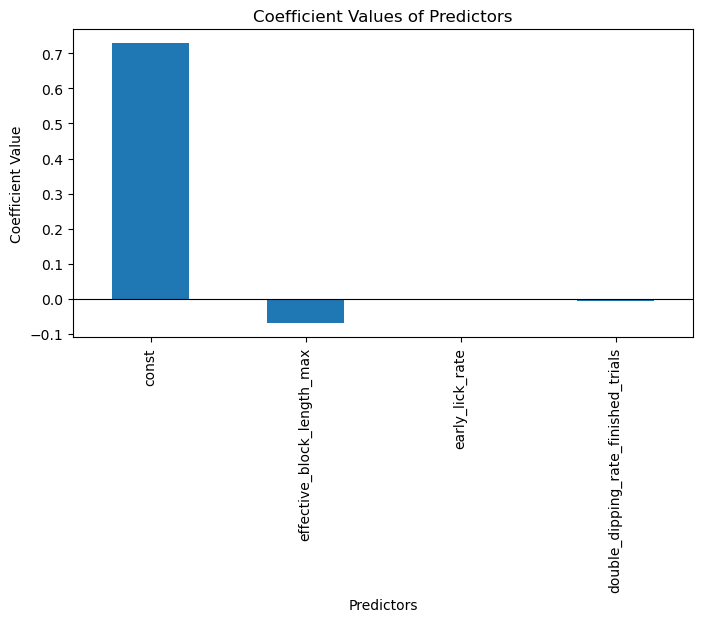

In [70]:
# Assuming 'model' is your fitted OLS model from statsmodels
coefficients = model.params
print("Coefficients:\n", coefficients)

# Plotting the coefficients
plt.figure(figsize=(8, 4))
coefficients.plot(kind='bar')
plt.title('Coefficient Values of Predictors')
plt.xlabel('Predictors')
plt.ylabel('Coefficient Value')
plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at zero
plt.show()


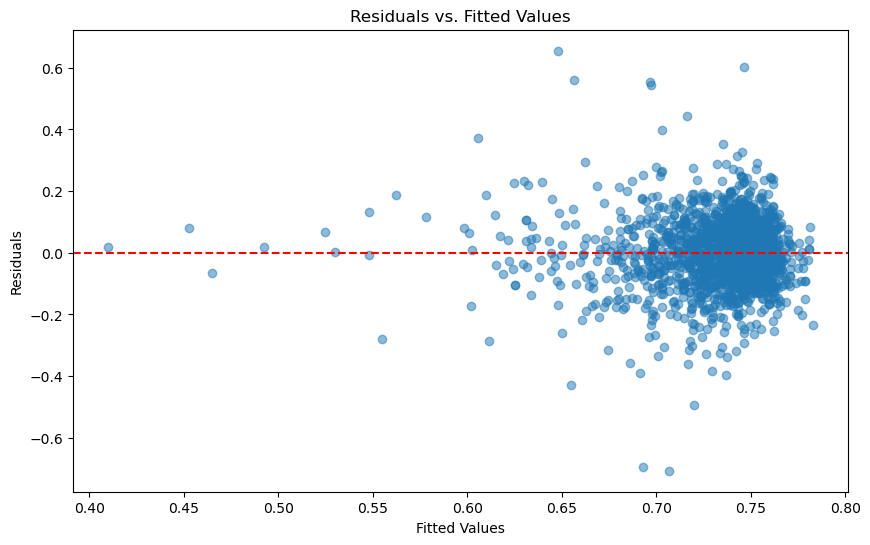

In [ ]:
residuals = model.resid

fitted_values = model.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Adds a horizontal line at zero
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

## Behavior meta data

### This master dataframe is the same as the one at https://foraging-behavior-browser.streamlit.app/, which is updated everyday.

In [4]:
df_sessions = pd.read_pickle(nwb_folder + '/df_sessions.pkl')
df_sessions.sort_values('session_date', ascending=False)

metadata                  \
                                                rig       user_name   
subject_id session_date session nwb_suffix                            
722683     2024-04-16   7.0     153946      447-3-C      Xinxin Yin   
717474     2024-04-16   5.0     155012      447-3-A      Xinxin Yin   
708299     2024-04-16   38.0    104116      447-2-D  Travis Ramirez   
711254     2024-04-16   22.0    153313      447-1-C      Xinxin Yin   
711256     2024-04-16   22.0    153649      447-2-C      Xinxin Yin   
...                                             ...             ...   
668463     2023-07-10   2.0     0           Tower-1           Lucas   
671087     2023-07-10   2.0     0           Tower-1          Travis   
668463     2023-07-07   1.0     1           Tower-1           Lucas   
671087     2023-07-06   1.0     0           Tower-1          Travis   
668551     2023-06-15   1.0     3           Tower-5           Lucas   

                                                                   \
                                           experiment_description   
subject_id session_date session nwb_suffix                          
722683     2024-04-16   7.0     153946                              
717474     2024-04-16   5.0     155012                              
708299     2024-04-16   38.0    104116                              
711254     2024-04-16   22.0    153313                              
711256     2024-04-16   22.0    153649                              
...                                                           ...   
668463     2023-07-10   2.0     0                                   
671087     2023-07-10   2.0     0                                   
668463     2023-07-07   1.0     1                                   
671087     2023-07-06   1.0     0                                   
668551     2023-06-15   1.0     3                                   

                                                                       \
                                                                 task   
subject_id session_date session nwb_suffix                              
722683     2024-04-16   7.0     153946              Uncoupled Baiting   
717474     2024-04-16   5.0     155012                        RewardN   
708299     2024-04-16   38.0    104116      Uncoupled Without Baiting   
711254     2024-04-16   22.0    153313              Uncoupled Baiting   
711256     2024-04-16   22.0    153649      Uncoupled Without Baiting   
...                                                               ...   
668463     2023-07-10   2.0     0                     Coupled Baiting   
671087     2023-07-10   2.0     0                     Coupled Baiting   
668463     2023-07-07   1.0     1                     Coupled Baiting   
671087     2023-07-06   1.0     0                     Coupled Baiting   
668551     2023-06-15   1.0     3             Coupled Without Baiting   

                                                                                               \
                                                                                        notes   
subject_id session_date session nwb_suffix                                                      
722683     2024-04-16   7.0     153946           input L 1, laser 1.5\ninput R 0.9, laser 1.5   
717474     2024-04-16   5.0     155012                                                          
708299     2024-04-16   38.0    104116                                                          
711254     2024-04-16   22.0    153313      Left input: 1, power: 1.5; Right input: 0.8, p...   
711256     2024-04-16   22.0    153649                           L 0.7v, 1.5mw\n R 0.8, 1.5mw   
...                                                                                       ...   
668463     2023-07-10   2.0     0                                                               
671087     2023-07-10   2.0     0                                                       

In [5]:
all_subject_ids = np.unique(df_sessions.index.get_level_values('subject_id').tolist())

In [6]:
desired_subject_ids = ['707337','698694','707535']  
feature = 'effective_block_length_max'
fe_changes = np.empty(0)
foraging_efficiencies = np.empty(0)
block_lengths = np.empty(0)

for desired_subject_id in all_subject_ids:

    # If 'subject_id' is part of a MultiIndex for rows
    subject_df = df_sessions[df_sessions.index.get_level_values('subject_id') == desired_subject_id]
    arrays = create_arrays(subject_df, feature)
    new_df = slice_dataframe(subject_df, feature)
    
    fe_change = np.diff(new_df['foraging_eff'])
    foraging_efficiency = new_df['foraging_eff']
    block_length = new_df['effective_block_length_max']
    
    if len(foraging_efficiency) == len(block_length):
        
        # hacky solution right now to the fact that otherwise they're not the same length 
        # at the end
    
        foraging_efficiencies = np.concatenate((foraging_efficiencies,foraging_efficiency))
        block_lengths = np.concatenate((block_lengths, block_length))
        #block_lengths.append(block_length)
    else:
        pass

In [7]:
np.nanmax(foraging_efficiencies)

1.3475873305423873

Text(0, 0.5, 'Foraging efficiency')

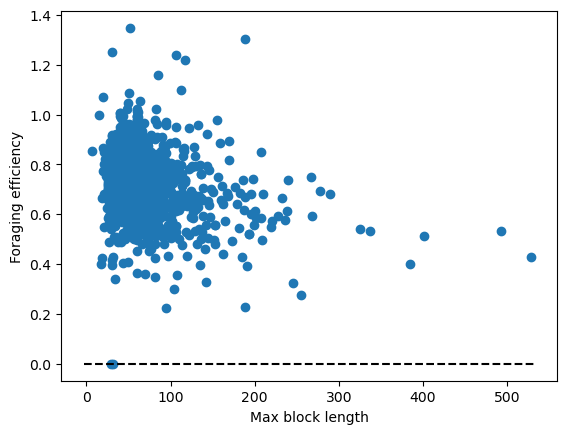

In [11]:
#fe_change = np.diff(new_df['foraging_eff'])
#block_length = new_df['effective_block_length_max'][2:]
plt.scatter(block_lengths,foraging_efficiencies)
plt.hlines(0,np.min(block_lengths)-5,np.max(block_lengths)+5, color='k', linestyle='--')
plt.xlabel('Max block length')
plt.ylabel('Foraging efficiency')

#plt.xlim([0,100])

In [7]:
# Assuming 'subject_id' is a column in the DataFrame and we are looking for 'subject_id' = YOUR_DESIRED_VALUE
desired_subject_id = '717377'  # Replace YOUR_DESIRED_VALUE with the actual subject_id you're interested in
feature = 'effective_block_length_max'

# If 'subject_id' is part of a MultiIndex for rows
subject_df = df_sessions[df_sessions.index.get_level_values('subject_id') == desired_subject_id]

In [ ]:
#df_sessions.metadata.columns

In [17]:
df_sessions.session_stats.columns

Index(['total_trials_with_autowater', 'finished_trials_with_autowater',
       'finished_rate_with_autowater', 'ignore_rate_with_autowater',
       'autowater_collected', 'autowater_ignored', 'total_trials',
       'finished_trials', 'ignored_trials', 'finished_rate', 'ignore_rate',
       'reward_trials', 'reward_rate', 'foraging_eff',
       'foraging_eff_random_seed', 'foraging_performance',
       'foraging_performance_random_seed', 'bias_naive',
       'reaction_time_median', 'reaction_time_mean', 'early_lick_rate',
       'invalid_lick_ratio', 'double_dipping_rate_finished_trials',
       'double_dipping_rate_finished_reward_trials',
       'double_dipping_rate_finished_noreward_trials',
       'lick_consistency_mean_finished_trials',
       'lick_consistency_mean_finished_reward_trials',
       'lick_consistency_mean_finished_noreward_trials'],
      dtype='object')

In [ ]:
# min_block_length = subject_df.metadata.effective_block_length_min.values
# min_block_lengths = np.unique(min_block_length)
# foraging_efficiency = subject_df.session_stats.foraging_eff.values

# print(foraging_efficiency)

In [336]:
arrays = create_arrays(subject_df, feature)

In [337]:
new_df = slice_dataframe(subject_df, feature)
new_df

,session_date,foraging_eff,effective_block_length_max
session,,,
1.0,2024-02-12,0.646388,30
2.0,2024-02-14,0.858023,35
3.0,2024-02-15,0.869327,35
4.0,2024-02-16,0.696760,71
5.0,2024-02-19,0.806064,43
6.0,2024-02-21,0.838489,35
7.0,2024-02-22,0.636414,52
8.0,2024-02-23,0.716541,35
9.0,2024-02-26,0.767177,35


(array([12.,  6.,  3.,  2.,  2.]),
 array([ 30. ,  52.8,  75.6,  98.4, 121.2, 144. ]),
 <BarContainer object of 5 artists>)

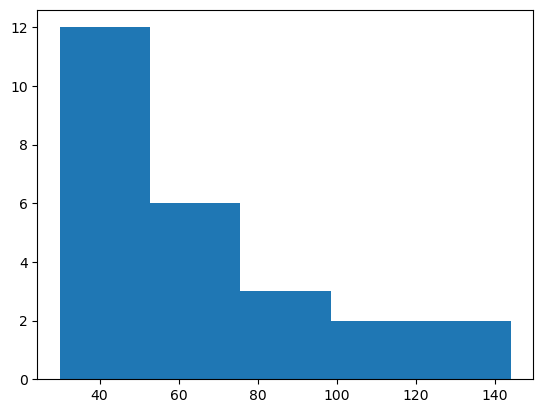

In [338]:
plt.hist(new_df.effective_block_length_max.values, bins=5)

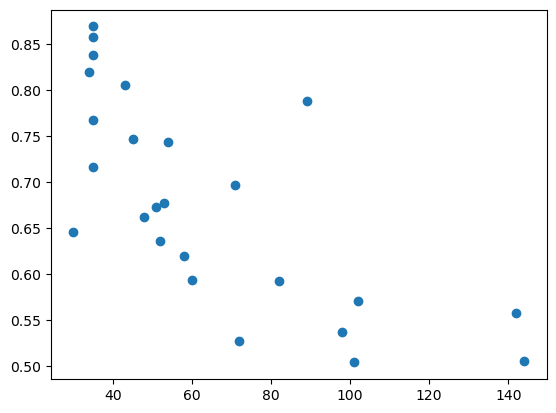

In [339]:
plt.scatter(new_df.effective_block_length_max.values, new_df.foraging_eff.values)

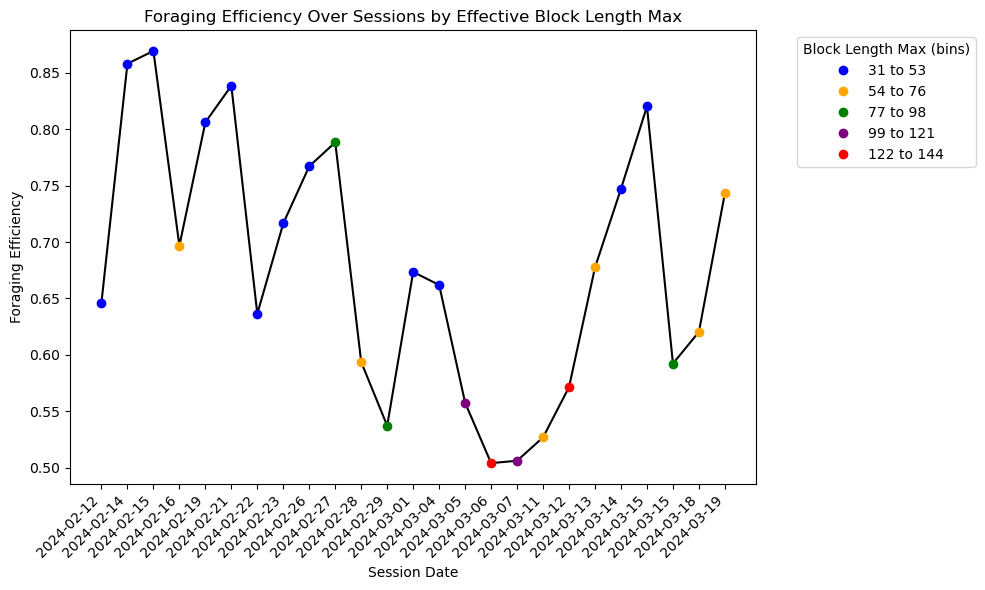

In [340]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'new_df' is your DataFrame with 'foraging_eff', 'effective_block_length_min', and 'session_date'

# Step 1: Create bins for 'effective_block_length_min'
bins = pd.cut(new_df['effective_block_length_max'], bins=5, right=False)
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define a color for each bin
bin_labels = [f'{interval.left+1:.0f} to {interval.right:.0f}' for interval in bins.cat.categories]
#new_first_bin = bin_labels[0].replace(bin_labels[0][1],str(int(bin_labels[0][1])-1)) # shift left edge of left category down by one/
#bin_labels[0] = new_first_bin

# Create a color map based on the bin
color_map = {bin: color for bin, color in zip(bins.cat.categories, colors)}
bin_colors = bins.map(color_map)

# Step 2: Plot with colors
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.arange(len(new_df['foraging_eff'])), new_df['foraging_eff'], linestyle='-', color='black')

legend_handles = []  # To keep track of legend handles
used_colors = [] # keep track of colors added to legend 

# Use a loop to plot each point so that we can assign colors individually
count = 0
for i, (session_date, row) in enumerate(new_df.iterrows()):
    
    # only add a legend if that color hasn't been plotted before
    if bin_colors.iloc[i] not in used_colors:
        ax.plot(i, row['foraging_eff'], marker='o', linestyle='', color=bin_colors.iloc[i], label=bin_labels[count])
        legend_handles.append(ax.lines[-1])  # Add the last line added to the legend handles
        used_colors.append(bin_colors.iloc[i])
        count+=1
        
    # otherwise, plot but don't add legend
    else:
        ax.plot(i, row['foraging_eff'], marker='o', linestyle='', color=bin_colors.iloc[i])



# Setting session dates as x-tick labels
ax.set_xticks(range(len(new_df)))
ax.set_xticklabels(new_df['session_date'], rotation=45, ha="right")

# Setting labels and title
ax.set_xlabel('Session Date')
ax.set_ylabel('Foraging Efficiency')
ax.set_title('Foraging Efficiency Over Sessions by Effective Block Length Max')

# Add legend
ax.legend(title='Block Length Max (bins)', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


/tmp/ipykernel_80/3278438110.py:2: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  block_length = new_df['effective_block_length_max'][2:]


Text(0, 0.5, 'FE change from previous day')

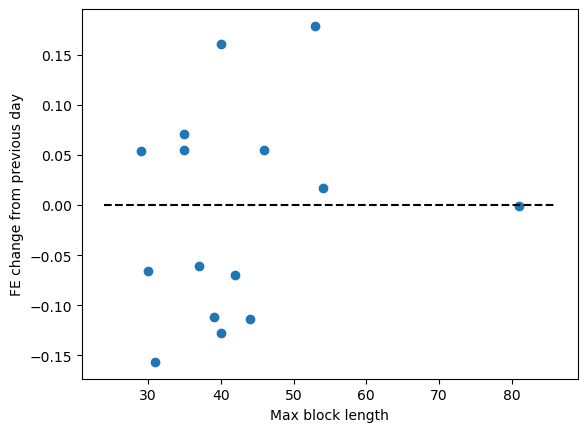

In [280]:
fe_change = np.diff(new_df['foraging_eff'])
block_length = new_df['effective_block_length_max'][2:]
plt.scatter(block_length,fe_change)
plt.hlines(0,np.min(block_length)-5,np.max(block_length)+5, color='k', linestyle='--')
plt.xlabel('Max block length')
plt.ylabel('FE change from previous day')

In [228]:
new_df['effective_block_length_max']

session
1.0      30
2.0      35
3.0      35
4.0      71
5.0      43
6.0      35
7.0      52
8.0      35
9.0      35
10.0     89
11.0     60
12.0     98
13.0     51
14.0     48
15.0    142
16.0    101
17.0    144
18.0     72
19.0    102
20.0     53
21.0     45
NaN      34
22.0     82
23.0     58
24.0     54
Name: effective_block_length_max, dtype: int64

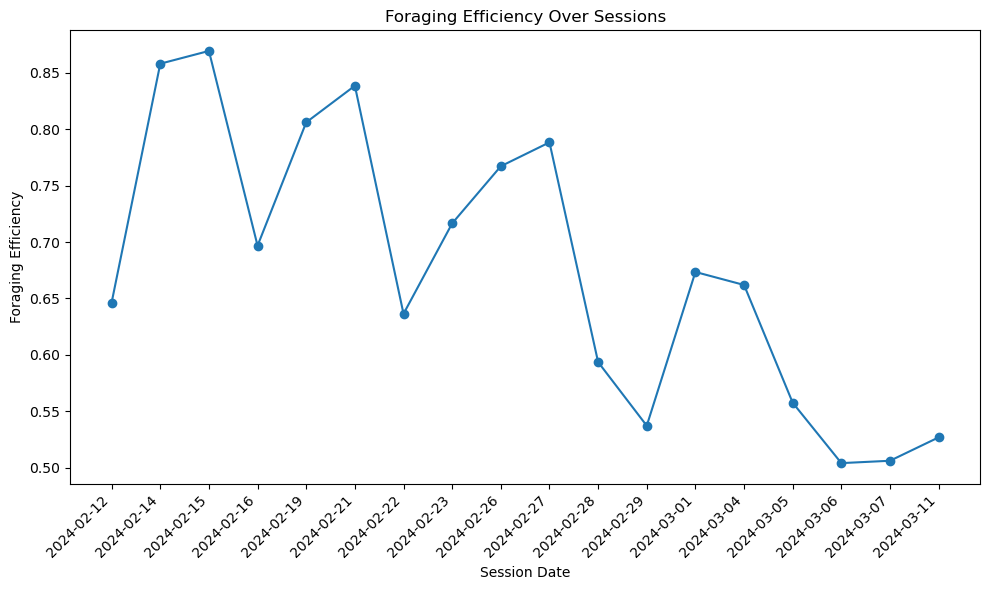

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot foraging_eff by session index
ax.plot(new_df.index, new_df['foraging_eff'], marker='o', linestyle='-')

# Set session dates as x-tick labels
ax.set_xticks(new_df.index)
ax.set_xticklabels(new_df['session_date'], rotation=45, ha="right")

# Setting labels and title
ax.set_xlabel('Session Date')
ax.set_ylabel('Foraging Efficiency')
ax.set_title('Foraging Efficiency Over Sessions')

plt.tight_layout()
plt.show()


## Load one session

In [87]:
nwb_file = '/XY_23/XY_23_20230508_52.nwb'

io = NWBHDF5IO(nwb_folder + nwb_file, mode='r')
nwb = io.read()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/root/capsule/data/foraging_nwb_bonsai_processed/XY_23/XY_23_20230508_52.nwb', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [8]:
nwb

root pynwb.file.NWBFile at 0x140705366887056
Fields:
  acquisition: {
    BehavioralEvents <class 'pynwb.behavior.BehavioralEvents'>
  }
  experiment_description: moving lickports, delay period, early lick punishment, sound GO cue then free choice
  experimenter: ['LucasK']
  file_create_date: [datetime.datetime(2023, 5, 10, 6, 12, 6, 903472, tzinfo=tzutc())]
  identifier: XY_23_20230508_151310_s52
  institution: Janelia Research Campus / Allen Institute
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <HDF5 dataset "keywords": shape (0,), type "|O">
  related_publications: ['']
  session_description: 1st no opto: 2nd opto
  session_start_time: 2023-05-08 15:13:10+00:00
  subject: subject pynwb.file.Subject at 0x140705366912592
Fields:
  date_of_birth: 2022-11-01 00:00:00+00:00
  description: XY_23
  sex: M
  species: mus musculus
  subject_id: 656489

  timestamps_reference_time: 2023-05-08 15:13:10+00:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'

## Behavioral trials

In [86]:
df_trials = nwb.trials.to_dataframe()
df_trials

NameError: name 'nwb' is not defined

In [10]:
df_trials.columns

Index(['start_time', 'stop_time', 'trial', 'task', 'task_protocol',
       'early_lick', 'outcome', 'auto_water', 'free_water', 'choice',
       'right_reward_prob', 'left_reward_prob', 'trial_bit_code',
       'photostim_side', 'photostim_power', 'photostim_on_to_go_cue',
       'photostim_off_to_go_cue', 'photostim_duration',
       'photostim_ramping_down', 'photostim_bpod_timer_align_to',
       'photostim_bpod_timer_offset', 'left_action_value',
       'right_action_value', 'rpe'],
      dtype='object')

### Trial view

<ipython-input-4-9eb85deb0729>:24: MatplotlibDeprecationWarning:

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.

<ipython-input-4-9eb85deb0729>:70: RuntimeWarning:

invalid value encountered in divide



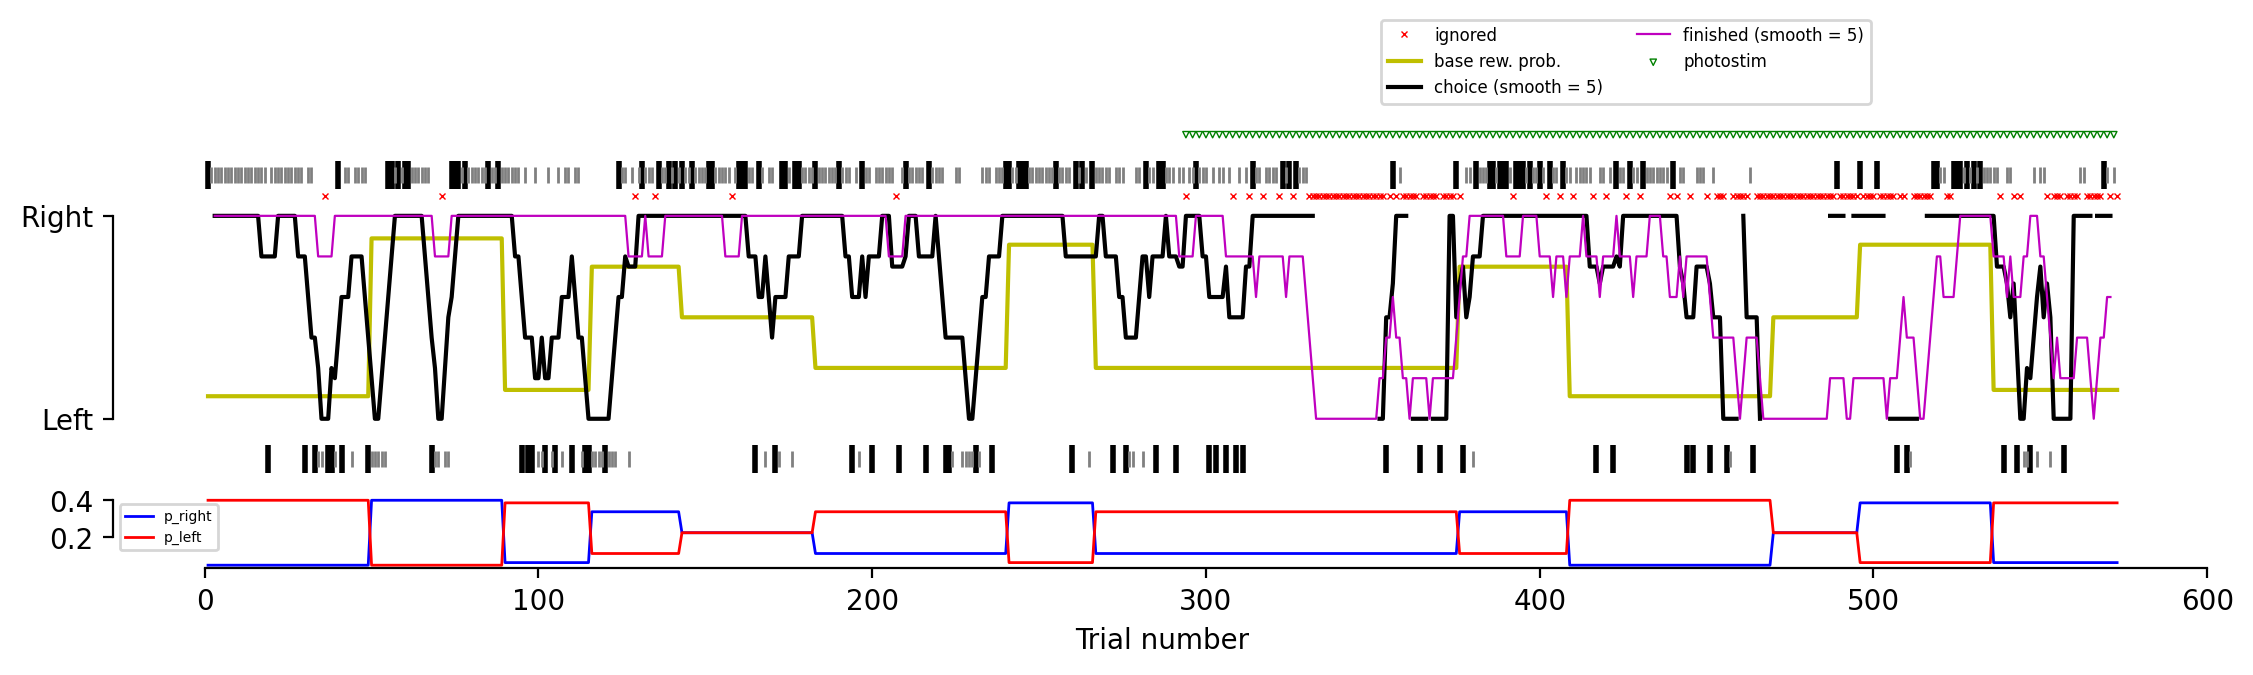

In [18]:
# Reformat data
_choice_history = df_trials.choice.values
choice_history = np.array([{'left': 0, 'right': 1, 'null': np.nan}[c] for c in _choice_history])

_reward = df_trials.outcome
reward_history = np.zeros([2, len(_reward)])  # .shape = (2, N trials)
for c in (0, 1):
    reward_history[c, choice_history==c] = (_reward[choice_history==c] == 'hit').astype(int)
    
p_reward = np.vstack([df_trials.left_reward_prob, df_trials.right_reward_prob])

# photostim
photostim_trials = df_trials.photostim_power > 0
photostim = [df_trials.trial[photostim_trials], df_trials.photostim_power[photostim_trials], df_trials.photostim_bpod_timer_align_to[photostim_trials]]

# Plot session
fig, ax = plot_session_lightweight([np.array([choice_history]), reward_history, p_reward], photostim=photostim)

## Behavioral events

#### Here is the trial structure

1. In the inter-trial-interval (ITI), lickports are far from the mice.
2. (Some sessions) at the trial start, lickports move forward to the "ready" position (`lickportready`, ephys only)
3. A "no-lick period" starts (relatively short in my experiments, ~0.2-0.5 sec)
4. In the "no-lick period", if there is a "early lick", add a 2 sec timeout, and go back to `3` (still in the same trial)
5. If there is no early lick, deliver a `go_cue` sound, and a "response window" starts (typically 5 sec)
6. If there is any lick in the response window:
    <br>i. The first lick after the go cue is considered as `choice`. Deliver reward if a reward exists on the chosen lickport ("hit"), otherwise, "miss"
   <br>ii. If there is no more lick in any 1-second window, go to `8`. (In other words, if the mouse keeps licking, the trial will become very long)
   <br>iii. If there is any lick to the other lickport than the "choice", this trial is "double-dipped". In part of experiments, the trial will be terminated (go to `8`) to discourage double-dipping.
7. If there is no lick in the response window, this trial is an "ignore" trial, and go to `8`.
8. `trialend`: lickports are retracted and IT starts.## Behavioral trials

In [13]:
behav_events = nwb.acquisition['BehavioralEvents']
behav_events

BehavioralEvents pynwb.behavior.BehavioralEvents at 0x140705366873136
Fields:
  time_series: {
    choice <class 'pynwb.base.TimeSeries'>,
    delay <class 'pynwb.base.TimeSeries'>,
    doubledip <class 'pynwb.base.TimeSeries'>,
    go <class 'pynwb.base.TimeSeries'>,
    laserLdown <class 'pynwb.base.TimeSeries'>,
    laserLoff <class 'pynwb.base.TimeSeries'>,
    laserLon <class 'pynwb.base.TimeSeries'>,
    left_lick <class 'pynwb.base.TimeSeries'>,
    reward <class 'pynwb.base.TimeSeries'>,
    right_lick <class 'pynwb.base.TimeSeries'>,
    trialend <class 'pynwb.base.TimeSeries'>
  }

For example, get all go cue times (all times are relative to the first trial start of a session, in sec)

In [ ]:
go_cue = behav_events['go'].timestamps[:]
print(go_cue[:20])
len(go_cue)

[  5.5157  12.719   18.2275  24.6772  30.7804  35.1772  39.4041  52.3391
  58.156   62.6499  69.2914  79.0224  83.3274  87.1776  91.3813  95.7574
  99.9148 105.1851 114.467  119.9647]


573

## Time view

In [16]:
event_color_map = {'go': 'green',
                   'choice': 'magenta', 
                   'right_lick': 'blue', 
                   'left_lick': 'red', 
                   'reward': 'cyan', 
                   'trialend': 'black'}

event_times = [behav_events[x].timestamps[:] for x in event_color_map]

# fig, ax = plt.subplots(1, 1, figsize=(20, 3))
# ax.eventplot(event_times, colors=list(event_color_map.values()), linelengths=0.6, lineoffsets=-1)
# ax.legend(event_color_map)
# ax.set_xlim((0, 500))
# ax.set(xlabel='Time (sec)')

In [17]:
import plotly.graph_objects as go

fig = go.Figure()

for n, event in enumerate(event_color_map.keys()):
    fig.add_trace(go.Scatter(
                            x=event_times[n],
                            y=np.full_like(event_times[n], 10 - n),
                            mode='markers',
                            marker=dict(symbol='line-ns',
                                        size=15,
                                        line_width=2,
                                        line_color=event_color_map[event],
                                        ),
                            name=event,
                            ))

# Set layout
fig.update_layout(
    xaxis=dict(title='Time (sec)'),
    yaxis=dict(showticklabels=False)
)

# Show the plot
fig.show()